# XGBoostによる分類モデルのテスト
最適なパラメータを探す
## データ準備

In [63]:
import re
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import nltk
from pprint import pprint
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics._scorer import _SCORERS
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer

In [64]:
df = pd.read_csv("./fake_job_postings.csv")
df = df.drop("job_id", axis=1) # job_id = 0,1,2,... 学習価値なし
# df.fillna('null', inplace=True) # 空の文字列 -> null (XGBoost APIでは無くてもいける？)

# 偽文書と本物文書
Fakedf = df[ df['fraudulent'] == 1 ]
Realdf = df[ df['fraudulent'] == 0 ]

# 問題文データのランダム抽出 (偽文書割合50%)
detaset_Fake, quiz_Fake = train_test_split(Fakedf, test_size=50)
detaset_Real, quiz_Real = train_test_split(Realdf, test_size=50)

# 問題文データのランダムシャッフル
quizdf = pd.concat([quiz_Real, quiz_Fake])
shuffled_df = quizdf.sample(frac=1).reset_index(drop=True)
quiz = shuffled_df.drop("fraudulent", axis=1)        # 問題文
quiz_solution = shuffled_df["fraudulent"].to_numpy() # 解答

# 訓練データとテストデータへの分割 (テストデータ25%)
train_Fake, test_Fake = train_test_split(detaset_Fake)
train_Real, test_Real = train_test_split(detaset_Real)
traindf = pd.concat([train_Real, train_Fake])
testdf = pd.concat([test_Real, test_Fake])
traindf = traindf.sample(frac=1).reset_index(drop=True)
testdf = testdf.sample(frac=1).reset_index(drop=True)
train_X = testdf.drop('fraudulent', axis=1)
train_y = testdf['fraudulent']
test_X = testdf.drop('fraudulent', axis=1)
test_y = testdf['fraudulent']

データの傾向を確認する。

In [65]:
print(train_X.head())

                                       title               location  \
0  Consulting Director - Sales Effectiveness  US, CA, San Francisco   
1                 Phone Sales Representative    US, NY, Farmingdale   
2             Contact Center Representatives      US, NV, Las Vegas   
3            Trend Editor/Berlin (Part time)         DE, BE, Berlin   
4                            Senior Sysadmin           GR, , Athens   

  department salary_range                                    company_profile  \
0        NaN          NaN  Talent Response connects flexible professional...   
1        NaN          NaN  For over 20 years NAC Marketing Company, LLC d...   
2        NaN          NaN  Tidewater Finance Co. was established in 1992 ...   
3        NaN          NaN  LHBS is an unconventional strategy firm with o...   
4        NOC          NaN  GRNET provides high-quality international and ...   

                                         description  \
0  Company BackgroundTalent Response

カテゴリカルデータの値と頻度を確認

In [66]:
category_columns = ['location','department','salary_range','employment_type','required_experience','required_education','industry','function']
for cc in category_columns:
    print(f"---{cc}---")
    pprint(train_X[cc].value_counts())

---location---
location
US, NY, New York         190
GB, LND, London          161
GR, I, Athens            121
US, CA, San Francisco    115
US, IL, Chicago           66
                        ... 
US, FL, Coral Springs      1
US, RI, Kingston           1
US, VA, Sterling           1
US, UT, Cedar City         1
CY, 02, Limassol           1
Name: count, Length: 1364, dtype: int64
---department---
department
Engineering                       141
Sales                             123
Marketing                          99
Operations                         69
IT                                 61
                                 ... 
Omaha                               1
New York City or Paris, France      1
Estimating                          1
RN                                  1
Systems Operations                  1
Name: count, Length: 540, dtype: int64
---salary_range---
salary_range
0-0              39
30000-40000      16
40000-50000      12
50000-70000      11
35000-45000      11


カテゴリカルデータをすべてOne-hot encodeするのは現実的ではない。

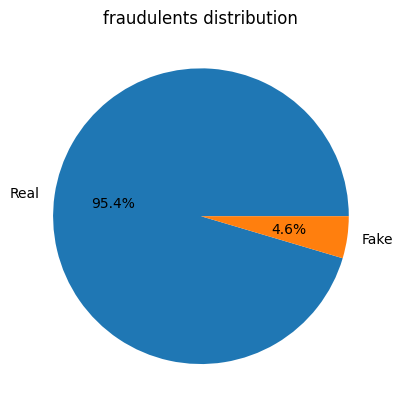

In [67]:
train_y.value_counts().rename(index={0: 'Real', 1: 'Fake'}).plot(kind='pie', autopct='%1.1f%%')
plt.title('fraudulents distribution')
plt.ylabel('')  # y軸ラベルを非表示にする
plt.show()

偽文書と本物文書の割合が不均衡のため、精度だけでモデル性能を評価するのは適切ではない。
不均衡なデータセットでは、多数派クラス（この場合はReal）を予測するだけで高い精度を達成できるため、モデルの真の性能を正確に反映しないことがある。

よって評価にはF1 score（適合率と再現率の調和平均）を用いる。
- 適合率（Precision）
  - 適合率はFakeと予測されたインスタンスのうち、実際にFakeである割合。
  - 積極的にRealと予測するとPrecisionが高くなる
- 再現率（Recall）
  - 再現率は、実際にFakeであるインスタンスのうち、正しくFakeと予測された割合です。
  - 積極的にFakeと予測するとRecallが高くなる
- 両者はトレードオフ関係にあり、バランスが大事

In [68]:
# 利用可能な評価指標
pprint(sorted(_SCORERS.keys()))

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

### 訓練データの加工
前処理を行って、データを扱いやすくする。

#### カテゴリカルデータのエンコード

In [69]:
encoded_train_X = pd.get_dummies(train_X, columns=['employment_type'])
encoded_test_X = pd.get_dummies(test_X, columns=['employment_type'])
print(encoded_train_X.columns)

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'required_experience',
       'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary'],
      dtype='object')


required_experienceとrequired_educationをレベル別に数値化する。

In [70]:
def int_convert(value):
    try:
        output = int(value)
        return output
    except ValueError:
        return np.nan
    
# required_experience
def encoder_experience(text):
    experience_levels = {
        "Not Applicable": 0,
        "Internship": 1,
        "Entry level": 2,
        "Associate": 3,
        "Mid-Senior level": 4,
        "Director": 5,
        "Executive": 6
    }
    return int_convert(experience_levels.get(text, np.nan))

# required_education
def encoder_education(text):
    education_levels = {
        "Unspecified": 0,
        "Some High School Coursework": 1,
        "High School or equivalent": 2,
        "Vocational - HS Diploma": 2,
        "Some College Coursework Completed": 3,
        "Associate Degree": 4,
        "Vocational - Degree": 5,
        "Certification": 5,
        "Bachelor's Degree": 5,
        "Professional": 6,
        "Master's Degree": 7,
        "Doctorate": 8
    }
    return int_convert(education_levels.get(text, np.nan))

In [71]:
# 二度以上実行するとすべて0になってしまうので注意
encoded_train_X['required_experience'] = encoded_train_X['required_experience'].apply(encoder_experience)
encoded_test_X['required_experience'] = encoded_test_X['required_experience'].apply(encoder_experience)
encoded_train_X['required_education'] = encoded_train_X['required_education'].apply(encoder_education)
encoded_test_X['required_education'] = encoded_test_X['required_education'].apply(encoder_education)

In [72]:
pprint(encoded_train_X['required_experience'].value_counts())
pprint(encoded_train_X['required_education'].value_counts())

required_experience
4.0    928
2.0    675
3.0    576
0.0    280
1.0     98
5.0     88
6.0     32
Name: count, dtype: int64
required_education
5.0    1336
2.0     522
0.0     348
7.0     106
4.0      70
3.0      22
6.0      20
8.0      10
1.0       8
Name: count, dtype: int64


salary_rangeを上限値と下限値でカラムを分ける。

In [73]:
def split_columns_salary(df):
    df['salary_lower'] = df['salary_range'].str.split('-').str[0].apply(int_convert)
    df['salary_upper'] = df['salary_range'].str.split('-').str[1].apply(int_convert)
    df = df.drop('salary_range', axis=1)
    # df['salary_lower'].fillna('null', inplace=True)
    # df['salary_upper'].fillna('null', inplace=True)
    return df

encoded_train_X = split_columns_salary(encoded_train_X)
encoded_test_X = split_columns_salary(encoded_test_X)

In [74]:
pprint(encoded_train_X['salary_lower'].value_counts())
pprint(encoded_train_X['salary_upper'].value_counts())

salary_lower
0.0         50
50000.0     46
40000.0     41
30000.0     39
80000.0     34
            ..
960000.0     1
21.0         1
143520.0     1
14500.0      1
500000.0     1
Name: count, Length: 140, dtype: int64
salary_upper
50000.0     41
0.0         39
40000.0     36
100000.0    36
45000.0     29
            ..
89000.0      1
105000.0     1
6000.0       1
96000.0      1
57000.0      1
Name: count, Length: 155, dtype: int64


地名を国名・州名・都市名で分ける。

In [75]:
def split_columns_location(df):
    df['country'] = df['location'].str.split(', ').str[0]
    df['region'] = df['location'].str.split(', ').str[1]
    df['city'] = df['location'].str.split(', ').str[2]
    df = df.drop('location', axis=1)
    # df['country'].fillna('null', inplace=True)
    # df['region'].fillna('null', inplace=True)
    # df['city'].fillna('null', inplace=True)
    return df

encoded_train_X = split_columns_location(encoded_train_X)
encoded_test_X = split_columns_location(encoded_test_X)

In [76]:
pprint(encoded_train_X['country'].value_counts())
pprint(encoded_train_X['region'].value_counts())
pprint(encoded_train_X['city'].value_counts())

country
US    2672
GB     581
GR     237
CA     114
DE      94
      ... 
LV       1
CZ       1
AM       1
CO       1
MY       1
Name: count, Length: 70, dtype: int64
region
       509
CA     497
NY     330
TX     250
LND    222
      ... 
BA       1
OL       1
DUR      1
PR       1
02       1
Name: count, Length: 219, dtype: int64
city
                  381
London            252
New York          193
Athens            145
San Francisco     117
                 ... 
Montréal            1
 Al Nashwa          1
Nicosia             1
New York Metro      1
Limassol            1
Name: count, Length: 1101, dtype: int64


#### Embedding
TF-IDF Vectorizer（[解説](https://www.analyticsvidhya.com/blog/2021/06/part-5-step-by-step-guide-to-master-nlp-text-vectorization-approaches/)）を用いてベクトル化。意味ある単語に重みが置かれる。

In [77]:
encoded_train_X.columns

Index(['title', 'department', 'company_profile', 'description', 'requirements',
       'benefits', 'telecommuting', 'has_company_logo', 'has_questions',
       'required_experience', 'required_education', 'industry', 'function',
       'employment_type_Contract', 'employment_type_Full-time',
       'employment_type_Other', 'employment_type_Part-time',
       'employment_type_Temporary', 'salary_lower', 'salary_upper', 'country',
       'region', 'city'],
      dtype='object')

In [78]:
text_columns = ['title', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'industry', 'function']
vectorized_train_X = copy.deepcopy(encoded_train_X)
vectorized_test_X = copy.deepcopy(encoded_test_X)

# ベクトル化
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(encoded_train_X[text_columns])
vectors_test = vectorizer.fit_transform(encoded_test_X[text_columns])

# スパース行列を密な形式に変換
vectorized_train_X[text_columns] = pd.DataFrame(vectors_train.toarray(), columns=vectorizer.get_feature_names_out(), dtype="float")
vectorized_test_X[text_columns] = pd.DataFrame(vectors_test.toarray(), columns=vectorizer.get_feature_names_out(), dtype="float")

print(vectorized_train_X.head())

   title  department  company_profile  description  requirements  benefits  \
0    0.0         0.0              0.0          0.0           0.0       0.0   
1    0.0         0.0              1.0          0.0           0.0       0.0   
2    0.0         1.0              0.0          0.0           0.0       0.0   
3    0.0         0.0              0.0          1.0           0.0       0.0   
4    0.0         0.0              0.0          0.0           0.0       0.0   

   telecommuting  has_company_logo  has_questions  required_experience  ...  \
0              0                 1              1                  5.0  ...   
1              0                 1              0                  2.0  ...   
2              0                 1              0                  2.0  ...   
3              0                 1              1                  NaN  ...   
4              0                 1              1                  NaN  ...   

   employment_type_Contract  employment_type_Full-time  

## モデル構築1 (文章加工なし)

In [79]:
model = xgb.XGBClassifier(random_state=0) # fix seed

parameters = {
    "n_estimators" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'objective' : ['binary:hinge'] # This makes 0 or 1, rather than producing probabilities.
}
model_opt = GridSearchCV(model, parameters, scoring="f1")
model_opt.fit(vectorized_train_X, train_y)
print(model_opt.best_params_)

In [ ]:
print(model_opt.best_score_)

0.28540528437080165


カテゴリカルデータを数値として扱うと精度が悪いので、DMatrixでカテゴリカルデータを正しく扱ってみる。DMatrixを既存のGridSearchCVでは扱えないので、自分で実装する

In [ ]:
dtrain = xgb.DMatrix(data=vectorized_train_X, label=train_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能
dtest = xgb.DMatrix(data=vectorized_test_X, label=test_y, enable_categorical=True) # カテゴリカルデータの分類は実験的機能

parameters = {
    "num_round" : [10, 20, 50, 100, 200, 500],
    "max_depth" : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
}

best_score = 0
best_params = None

# パラメータのすべての組み合わせに対してループ
for params in product(*parameters.values()):
    param_dict = dict(zip(parameters.keys(), params))

    # 警告回避のためnum_roundだけ除外
    given_param = {
        "max_depth" : param_dict["max_depth"],
        'objective' : 'binary:hinge' # This makes 0 or 1, rather than producing probabilities.
    }
    num_round = param_dict["num_round"]
    
    # モデルの訓練と評価
    trained_model = xgb.train(given_param, dtrain, num_round)
    prediceted_y = trained_model.predict(dtest)
    score = f1_score(test_y, prediceted_y)

    # ベストスコアの更新
    if score > best_score:
        best_score = score
        best_params = param_dict

print("Best Score:", best_score)
print("Best Parameters:", best_params)

Best Score: 0.5360824742268041
Best Parameters: {'num_round': 50, 'max_depth': 10}


精度は最大でも54%と当てずっぽうに近い結果となった。

## モデル構築2 (文章加工あり)
前処理を行ってからベクトル化する。

In [ ]:
# 処理前データ読み込み
text_columns = ['title', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'industry', 'function']
processed_train_X = copy.deepcopy(encoded_train_X)
processed_test_X = copy.deepcopy(encoded_test_X)

In [ ]:
def convert_lower(text):
    try:
        # 英字と空白（スペース、タブ、改行など）以外の文字を取り除く
        cleaned_text = re.sub(r'[^a-zA-Z\s]','',text) 
        lower_text = cleaned_text.lower()
        return lower_text
    except TypeError: # NaNの入力
        return text

# すべて小文字にする
processed_train_X[text_columns] = processed_train_X[text_columns].map(convert_lower)
processed_test_X[text_columns] = processed_test_X[text_columns].map(convert_lower)

print(processed_train_X[text_columns].head())

                             title          location        department  \
0  customer service representative     us ga atlanta  customer service   
1      mystery shopper  new mexico  us nm farmington               NaN   
2       customer service associate      us ma boston               NaN   
3                software engineer   us oh cleveland               NaN   
4             junior ios developer       gr i athens               NaN   

                                     company_profile  \
0  since  allied secured benefits a leading finan...   
1  sdi marketing started in  as a small marketing...   
2  novitex enterprise solutions formerly pitney b...   
3  we provide full time permanent positions for m...   
4  parkaround ex parking defenders is an athensba...   

                                         description  \
0  if you are passionate about helping people you...   
1  would you like to get paid to use your smart p...   
2  the customer service associate will be based i.

レンマタイゼーション（Lemmatization）によって単語を基本形または辞書形（レンマ）に変換する。

レンマタイゼーションの特徴と利点
- 意味の保持
  - ステミングは単に単語の末尾を切り取る。例えば「running」は「run」になる。
  - レンマタイゼーションは単語の意味を考慮する。例えば「better」のレンマは「good」になる。
- 計算コストが高い

In [ ]:
# ワードリストをダウンロード
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# WordNetLemmatizerの初期化
lemmatizer = WordNetLemmatizer()

# NaN対策
def safe_lemmatizer(text):
    try:
        converted_text = lemmatizer.lemmatize(text) 
        return converted_text
    except AttributeError: # NaNの入力
        return text

# レンマタイゼーション
processed_train_X[text_columns] = processed_train_X[text_columns].map(safe_lemmatizer)
processed_test_X[text_columns] = processed_test_X[text_columns].map(safe_lemmatizer)

print(processed_train_X[text_columns].head())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\katai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


                             title          location        department  \
0  customer service representative     us ga atlanta  customer service   
1      mystery shopper  new mexico  us nm farmington               NaN   
2       customer service associate      us ma boston               NaN   
3                software engineer   us oh cleveland               NaN   
4             junior ios developer       gr i athens               NaN   

                                     company_profile  \
0  since  allied secured benefits a leading finan...   
1  sdi marketing started in  as a small marketing...   
2  novitex enterprise solutions formerly pitney b...   
3  we provide full time permanent positions for m...   
4  parkaround ex parking defenders is an athensba...   

                                         description  \
0  if you are passionate about helping people you...   
1  would you like to get paid to use your smart p...   
2  the customer service associate will be based i.

In [178]:
# ストップワードを除去しながら変換
vectorizer = TfidfVectorizer(stop_words='english')